This project is going to, overall:
1- read in a dataset of real estate transactions over a multi-year period and clean it

2- use regression techniques to identify factors relevant to pricing -- including 'seasonality' effects (is there a seasonal penalty
   in winter above and beyond the 'fundamentals' that approximate the 'quality' of the home)

3- test the predictive power of a random forest model (as compared to the regression) -- should capture complex interrelationships
   between variables, will yield relative-importance estimates

4- use unsupervised learning algorithms to construct Neighborhoods, compare them to the city's 'official' categorization
   this may require subsetting the data geographically, so that we're in a smaller category space

Goals for this file:
- read data files (they're both csvs -- one is sales, the other is characteristics of every lot)

- merge and filter for the desired subset of observations: single-family residential lots in the sales set

- drop some of the non-applicable/empty columns (i.e. for commercial zoning) -- probably using documentation

- split out some rows for 'final scoring'

In [1]:
# Standard imports for data analysis packages in Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This enables inline Plots
%matplotlib inline

# Limit rows displayed in notebook
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 2)

In [2]:
pd.__version__

u'0.17.1'

In [3]:
df1 = pd.read_csv('property_sales.csv', low_memory=False, error_bad_lines=False)
df2 = pd.read_csv('residential_chars.csv', low_memory=False, error_bad_lines=False)

Skipping line 41748: expected 16 fields, saw 17

Skipping line 62074: expected 46 fields, saw 47
Skipping line 62077: expected 46 fields, saw 47
Skipping line 62080: expected 46 fields, saw 47
Skipping line 66636: expected 46 fields, saw 48



In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186316 entries, 0 to 186315
Data columns (total 16 columns):
SCHEDNUM          186316 non-null int64
RECEPTION_NUM     186316 non-null object
INSTRUMENT        186316 non-null object
SALE_YEAR         186316 non-null int64
SALE_MONTHDAY     186316 non-null int64
RECEPTION_DATE    186316 non-null int64
SALE_PRICE        125045 non-null float64
GRANTOR           186316 non-null object
GRANTEE           186316 non-null object
CLASS             186316 non-null object
MKT_CLUS          177329 non-null float64
D_CLASS           186316 non-null object
D_CLASS_CN        186294 non-null object
NBHD_1            186316 non-null int64
NBHD_1_CN         186314 non-null object
PIN               186316 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 24.2+ MB


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197687 entries, 0 to 197686
Data columns (total 46 columns):
PIN                 197687 non-null int64
SCHEDNUM            197687 non-null int64
CD                  197687 non-null int64
OFCARD              197687 non-null int64
OWNER               197687 non-null object
CO_OWNER            6013 non-null object
OWNER_NUM           197687 non-null object
OWNER_DIR           103696 non-null object
OWNER_ST            197684 non-null object
OWNER_TYPE          191155 non-null object
OWNER_APT           38891 non-null object
OWNER_CITY          197687 non-null object
OWNER_STATE         197686 non-null object
OWNER_ZIP           197664 non-null object
SITE_NBR            197687 non-null int64
SITE_DIR            110645 non-null object
SITE_NAME           197687 non-null object
SITE_MODE           197543 non-null object
SITE_MORE           48773 non-null object
TAX_DIST            197687 non-null object
PROP_CLASS          197666 non-null fl

In [7]:
# merge on PIN (in pandas)... want to drop commercial from df1, unsold from df2
# need to see if dups cause a problem -- we want them in the final file

In [6]:
df1['D_CLASS_CN'].nunique()
# we know a priori that this file contains a lot of non-residential property types

166

In [7]:
print df2['D_CLASS_CN'].nunique()
# this file is listed as "residential", but it actually contains a couple dozen different zoning categories
print df2['D_CLASS_CN'].unique()

64
['SINGLE FAMILY' 'ROWHOUSE' 'CONDOMINIUM' 'MISC ROWHOUSE IMPS'
 'VCNT LAND B-3 BA3 CCN' 'VCNT LAND R-2, RS-2 ZONE' 'OTHER REC FACILITIES'
 'PAVED LOT' 'VCNT LAND BA-2 ZONE' 'VCNT LAND 0-1 ZONE'
 'AGR VCNT LAND IN GWD' 'PUD VCNT LAND' 'VCNT LAND R-0 & R-1 ZONE'
 'DENVER HOUSING AUTHORITY' 'GENERAL COMMON ELEMENTS'
 'VCNT LAND - RES RATIO' 'VCNT LAND B4 BA4 ZONE'
 'PAVED LOT W/ LIGHT OR FENCING' 'CITY LEASED BUILDING' 'DIA'
 'VCNT LAND B-7 ZONE' 'SENIOR CITIZEN HOMES' 'VCNT LAND RS-4 ZONE'
 'SURFACING' 'DCL MISC RES IMPS' 'MISC IMPS-TIE BACK' 'ALL OTHERS'
 'VCNT LAND R-X ZONE' 'PARSONAGE' 'CITY & COUNTY OF DENVER'
 'VCNT LAND W/MINOR STR' 'VCNT LAND I-1 ZONE' 'MOBILE HOME - IMP ONLY'
 'VCNT LAND I-2 ZONE' 'VCNT LAND I-0 ZONE' 'VCNT LAND R-3, R-3X ZONE'
 'VCNT LAND R-5 ZONE' 'SCHOOL DISTRICT NO. 1' 'CHURCH OWNED SFR'
 'DENVER PARK' 'STATE ASSESSED PROPERTIES' 'RR OWNED VCT LAND/MISCIMP'
 '101 CONDO PKG' '10S CONDO STORAGE' 'VCNT LAND B-8 ZONE'
 'VCNT LAND PRV ZONE' '100 MISC CONDO' 'MI

In [8]:
# So before we merge the files together, let's filter for the types that seem clearly useful for our study
res_types = ['SINGLE FAMILY', 'ROWHOUSE', 'APT W/3 UNITS']

# let's test the merge code etc on one class first
df1a = df1[df1['D_CLASS_CN'] == 'SINGLE FAMILY']
df2a = df2[df2['D_CLASS_CN'] == 'SINGLE FAMILY']

In [9]:
df_full = pd.merge(df1a, df2a, how='left', on='SCHEDNUM')

In [10]:
print df_full.info()
df_full.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 111892 entries, 0 to 111891
Data columns (total 61 columns):
SCHEDNUM            111892 non-null int64
RECEPTION_NUM       111892 non-null object
INSTRUMENT          111892 non-null object
SALE_YEAR           111892 non-null int64
SALE_MONTHDAY       111892 non-null int64
RECEPTION_DATE      111892 non-null int64
SALE_PRICE          74415 non-null float64
GRANTOR             111892 non-null object
GRANTEE             111892 non-null object
CLASS               111892 non-null object
MKT_CLUS            111868 non-null float64
D_CLASS             111892 non-null object
D_CLASS_CN_x        111892 non-null object
NBHD_1_x            111892 non-null int64
NBHD_1_CN_x         111892 non-null object
PIN_x               111892 non-null int64
PIN_y               111861 non-null float64
CD                  111861 non-null float64
OFCARD              111861 non-null float64
OWNER               111861 non-null object
CO_OWNER            2785 non-nu

,SCHEDNUM,RECEPTION_NUM,INSTRUMENT,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,GRANTOR,GRANTEE,CLASS,...,UNITS,ASMT_APPR_LAND,TOTAL_VALUE,ASDLAND,ASSESS_VALUE,ASMT_TAXABLE,ASMT_EXEMPT_AMT,NBHD_1_y,NBHD_1_CN_y,LEGL_DESCRIPTION
0,4100122000,2008170400,PR,2008,1212,20081222,NaN,"REITHER,JOHN G & CLARA","REITHER,JOHN FAMILY TRUST &",R,...,1,0,136200,0,10842,10840,0,4,GATEWAY N,T3 R66 S4 SW/4 E 660FT EXC S 30FT OF SD SEC ...
1,14101001000,2009074518,WD,2009,605,20090615,299000,"ATKINSON,RUSSELL","PADBURY,CHRISTOPHER R",R,...,1,30000,300800,2388,23944,23950,0,5,N GREEN VALLEY,GREEN VALLEY RANCH FLG #36 B1 L1
2,14101001000,2009002129,WD,2008,1024,20090108,10,DREAM BUILDERS LLC,"ATKINSON,RUSSELL",R,...,1,30000,300800,2388,23944,23950,0,5,N GREEN VALLEY,GREEN VALLEY RANCH FLG #36 B1 L1
3,14101001000,2008138043,WD,2008,703,20081008,10,"ATKINSON,RUSSELL",DREAM BUILDERS LLC,R,...,1,30000,300800,2388,23944,23950,0,5,N GREEN VALLEY,GREEN VALLEY RANCH FLG #36 B1 L1
4,14101002000,2010094573,WD,2010,823,20100824,350000,"SHEARON,MARK H &","EFREM,TEWEDROS",R,...,1,30000,414700,2388,33010,33010,0,5,N GREEN VALLEY,GREEN VALLEY RANCH FLG #36 B1 L2


In [ ]:
# now, we drop properties where SALE_PRICE is below some arbitrary threshold, since we don't expect
# foreclosure auctions, nominal 'sales' between family members, etc to be very predictable

In [11]:
# does INSTRUMENT help us determine which sales are 'not useful' (e.g. non-predictive)?
df_inst = df_full.groupby('INSTRUMENT').SALE_PRICE.agg(['sum', 'count'])
df_inst['avg'] = df_inst['sum'] / df_inst['count']
df_inst

,sum,count,avg
INSTRUMENT,,,
AD,2.16e+06,13,166361.54
AF,5.24e+05,4,130942.50
BF,1.00e+01,1,10.00
BG,2.02e+07,80,252799.65
BS,4.74e+07,144,329065.41
...,...,...,...
SW,7.69e+09,10949,702244.87
TR,2.34e+07,130,179728.22
TS,3.32e+03,4,829.25


In [12]:
# looks promising...
a = df_inst.avg < 150000
df_inst[a==True]

,sum,count,avg
INSTRUMENT,,,
AF,523770,4,130942.50
BF,10,1,10.00
CD,1467760,11,133432.73
DC,133,15,8.87
DD,11591812,126,91998.51
DS,11,2,5.50
PS,79000,1,79000.00
QC,56223597,8692,6468.43
ST,10,1,10.00


In [13]:
# INSTRUMENT == QC is likely "quit claims", which are used when the sale carries no guarantee of clear title...
# wiki notes that the two main use cases are 1) transfers btwn family members 2) tax auction sales by govt
# this doesn't seem germane to the project

# others of these sale types with low average prices are likely other types of 'distressed' sale, as well, and we should consider
# whether we want to throw out all low-priced sales, all sales of certain types, or some combination of both
df_full[df_full.INSTRUMENT == 'QC'].SALE_PRICE.max()

9200000.0

In [13]:
df3 = df_full[df_full.SALE_PRICE > 100000]

In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56330 entries, 1 to 111891
Data columns (total 61 columns):
SCHEDNUM            56330 non-null int64
RECEPTION_NUM       56330 non-null object
INSTRUMENT          56330 non-null object
SALE_YEAR           56330 non-null int64
SALE_MONTHDAY       56330 non-null int64
RECEPTION_DATE      56330 non-null int64
SALE_PRICE          56330 non-null float64
GRANTOR             56330 non-null object
GRANTEE             56330 non-null object
CLASS               56330 non-null object
MKT_CLUS            56323 non-null float64
D_CLASS             56330 non-null object
D_CLASS_CN_x        56330 non-null object
NBHD_1_x            56330 non-null int64
NBHD_1_CN_x         56330 non-null object
PIN_x               56330 non-null int64
PIN_y               56311 non-null float64
CD                  56311 non-null float64
OFCARD              56311 non-null float64
OWNER               56311 non-null object
CO_OWNER            931 non-null object
OWNER_NUM  

In [15]:
df4 = df3[df3.INSTRUMENT != 'QC']

In [16]:
df5 = df4[df4.PROPERTY_CLASS == 'Single Family Residential']

In [17]:
pd.qcut(df5.SALE_PRICE,4)
# So these pricing restrictions bring us down to 56,000 records (sale price > 100k, not a 'quit claim' deed, single fam residential)

# The artificial low-end cutoff on prices will hurt our model a little, because we're keeping the whole right tail
# but cutting the left tail short -- the difficulty is that at lower prices, we have a hard time telling the difference
# between an inexpensive "open market" sale and an "in-family" or "distressed" sale, that is operating under a
# different set of pricing dynamics.
# When we actually deploy the various models, we can explore ways to compensate for this artificial skew

1           (275000, 419000]
4           (275000, 419000]
5           (275000, 419000]
10          (275000, 419000]
13          (180000, 275000]
                 ...        
111887    (419000, 49500000]
111888    (419000, 49500000]
111889    (419000, 49500000]
111890    (419000, 49500000]
111891    (419000, 49500000]
Name: SALE_PRICE, dtype: category
Categories (4, object): [[100010, 180000] < (180000, 275000] < (275000, 419000] < (419000, 49500000]]

In [18]:
df5.CLASS.unique()

array(['R', 'A', 'X', 'H'], dtype=object)

In [19]:
x_keep = ['SCHEDNUM', 'RECEPTION_NUM', 'INSTRUMENT', 'RECEPTION_DATE', 'CLASS', 'D_CLASS', 'NBHD_1_x', 'NBHD_1_CN_x', 'OFCARD', 'SITE_NBR', 
        'SITE_DIR', 'SITE_NAME', 'SITE_MODE', 'SITE_MORE', 'TAX_DIST',  'LAND_SQFT', 'AREA_ABG', 'BSMT_AREA', 'FBSMT_SQFT', 'GRD_AREA', 
        'STORY', 'BED_RMS', 'FULL_B', 'HLF_B', 'CCYRBLT', 'CCAGE_RM', 'SALE_PRICE']
y_col = ['SALE_PRICE']

In [20]:
df6 = df5.ix[:,x_keep]

y = df5.ix[:,y_col]

In [21]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56105 entries, 1 to 111891
Data columns (total 27 columns):
SCHEDNUM          56105 non-null int64
RECEPTION_NUM     56105 non-null object
INSTRUMENT        56105 non-null object
RECEPTION_DATE    56105 non-null int64
CLASS             56105 non-null object
D_CLASS           56105 non-null object
NBHD_1_x          56105 non-null int64
NBHD_1_CN_x       56105 non-null object
OFCARD            56105 non-null float64
SITE_NBR          56105 non-null float64
SITE_DIR          29488 non-null object
SITE_NAME         56105 non-null object
SITE_MODE         56097 non-null object
SITE_MORE         641 non-null object
TAX_DIST          56105 non-null object
LAND_SQFT         56076 non-null float64
AREA_ABG          56105 non-null float64
BSMT_AREA         56105 non-null float64
FBSMT_SQFT        56105 non-null float64
GRD_AREA          56105 non-null float64
STORY             56105 non-null float64
BED_RMS           56105 non-null float64
FULL_B

In [ ]:
# I'm still on the fence about how/whether to include some of these in the actual model -- the address, for example, would be quite
# messy to model, and some of the sparser site characteristics (TAX_DIST, GRD_AREA) may carry too much weight when we regress, 
# so we may want to consider some kind of single measure of basement space (plus a 'finished' binary if FBSMT or GRD > 0), for example

In [22]:
df6.to_csv('saleprice_df.csv')

In [ ]:
# In the next notebook, we'll build on this df

In [23]:
df = pd.read_csv('saleprice_df.csv')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56105 entries, 0 to 56104
Data columns (total 28 columns):
Unnamed: 0        56105 non-null int64
SCHEDNUM          56105 non-null int64
RECEPTION_NUM     56105 non-null int64
INSTRUMENT        56105 non-null object
RECEPTION_DATE    56105 non-null int64
CLASS             56105 non-null object
D_CLASS           56105 non-null int64
NBHD_1_x          56105 non-null int64
NBHD_1_CN_x       56105 non-null object
OFCARD            56105 non-null float64
SITE_NBR          56105 non-null float64
SITE_DIR          29488 non-null object
SITE_NAME         56105 non-null object
SITE_MODE         56097 non-null object
SITE_MORE         641 non-null object
TAX_DIST          56105 non-null object
LAND_SQFT         56076 non-null float64
AREA_ABG          56105 non-null float64
BSMT_AREA         56105 non-null float64
FBSMT_SQFT        56105 non-null float64
GRD_AREA          56105 non-null float64
STORY             56105 non-null float64
BED_RMS    

In [25]:
df['SALES_YR'] = df['RECEPTION_DATE'].map(lambda x : str(x)[:4]).astype('int')
df['SALES_MONTH'] = df['RECEPTION_DATE'].map(lambda x : str(x)[4:6]).astype('str')

In [26]:
df['SALES_DATE'] = df['SALES_YR'].astype('str')+df['SALES_MONTH']

In [27]:
df2 = df[df.SALES_YR >= 2008]
price = df2.groupby('SALES_DATE').SALE_PRICE.median()
quantity = df2.groupby('SALES_DATE').SCHEDNUM.count()

In [28]:
price

SALES_DATE
200801    219642.5
200802    249700.0
200803    260100.0
200804    265000.0
200805    245000.0
            ...   
201409    318500.0
201410    320000.0
201411    317000.0
201412    313500.0
201501    300000.0
Name: SALE_PRICE, dtype: float64

### plotting price over time

In [29]:
df_b = pd.read_table('comparisons.csv', header=0, names=['date', 'Case-Shiller', 'Zillow'])

In [30]:
df_b.head()

,date,Case-Shiller,Zillow
0,2008-01-01,130.93,242400
1,2008-02-01,130.30,240500
2,2008-03-01,130.40,238800
3,2008-04-01,130.19,237500
4,2008-05-01,130.12,237000


In [31]:
df_b['date2'] = df_b['date'].map(lambda x : str(x)[:4]+str(x)[5:7]).astype('str')
df_b2 = df_b.drop(['date'], axis=1)

In [32]:
w4 = pd.DataFrame({'Median_Price': df2.groupby('SALES_DATE').SALE_PRICE.median()}).reset_index()


In [33]:
w4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Data columns (total 2 columns):
SALES_DATE      85 non-null object
Median_Price    85 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [34]:
df_b3 = pd.concat([df_b2, w4], axis=1)

In [35]:
df_b3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Data columns (total 5 columns):
Case-Shiller    84 non-null float64
Zillow          85 non-null int64
date2           85 non-null object
SALES_DATE      85 non-null object
Median_Price    85 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.0+ KB


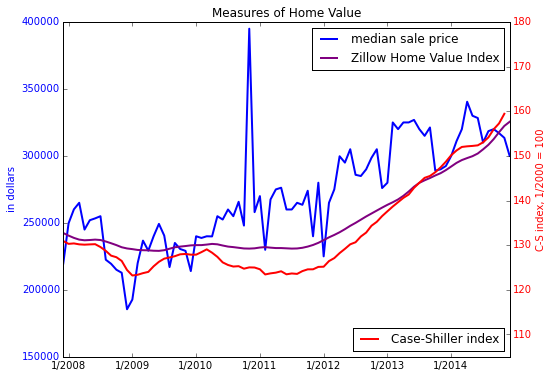

In [36]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.set_title('Measures of Home Value')

ax1.plot(df_b3.index, df_b3.Median_Price, lw=2, color="blue", label="median sale price")
ax1.set_ylabel("in dollars", color="blue")
for label in ax1.get_yticklabels():
    label.set_color("blue")
    
ax1.set_xticks([1, 13, 25, 37, 49, 61, 73, 85])
ax1.set_xticklabels(['1/2008', '1/2009', '1/2010', '1/2011', '1/2012', '1/2013', '1/2014', '1/2015'])
ax1.plot(df_b3.index, df_b3.Zillow, lw=2, c='purple', label="Zillow Home Value Index")
    
ax2 = ax1.twinx()
ax2.plot(df_b3.index, df_b3['Case-Shiller'], lw=2, color="red", label="Case-Shiller index")
ax2.set_ylim([105,180])
ax2.set_ylabel("C-S index, 1/2000 = 100", color="red")
for label in ax2.get_yticklabels():
    label.set_color("red")
    
ax1.legend(loc=0)
ax2.legend(loc=4)

fig.savefig("value_measures.png")

In [ ]:
# So this is a good start -- we have the dataframes we want to work with, we've done some sanity checks, 
# and the median sale price has been validated by a couple of external indices.